In [1]:
import numpy as np
from matplotlib import pyplot as plt
import os, sys, time

# Add to PYTHONPATH the path to local libraries
paospath = "~/git/PAOS"
if not os.path.expanduser(paospath) in sys.path:
    sys.path.append( os.path.expanduser(paospath) )

import paos

In [2]:
CAF2 = {'source': 'Handbook of Optics Vol. II',
        'Tref': 20.0 }
CAF2['sellmeier'] = {
    'K1': 5.67588800E-001,
    'L1': 2.52643000E-003,
    'K2': 4.71091400E-001,
    'L2': 1.00783330E-002,
    'K3': 3.84847230E+000,
    'L3': 1.20055600E+003
}
CAF2['Tmodel'] = {
    'D0': -2.6600E-005
}

SAPPHIRE = {'source': 'The Infrared & Electro-Optical Systems Handbook V. III',
            'Tref': 20.0}
SAPPHIRE['sellmeier'] = {
    'K1': 1.023798000E+00,
    'L1': 3.775880000E-03,
    'K2': 1.058264000E+00,
    'L2': 1.225440000E-02,
    'K3': 5.280792000E+00,
    'L3': 3.213616000E+02
}
SAPPHIRE['Tmodel'] = {
    'D0': 1.80000000E-05
}


In [3]:
def sellmeier(wl, par):
    """
    Implements the Sellmeier 1 equation to estimate the glass
    index of refraction relative to air at the glass reference temperature, 
    Tref = 20oC, and pressure, Pref=1atm.
    
    Parameters
    ----------
    wl: scalar or array
        wavelength in microns
    par: dict
        dictionary containing the 'K1', 'L1', 'K2', 'L2', 'K3', 'L3'
        parameters of the Sellmeier 1 model
    
    Returns
    -------
    out: the refractive index
    """
    wl2 = wl**2
    n2_1  = par['K1']*wl2 / (wl2 - par['L1'])
    n2_1 += par['K2']*wl2 / (wl2 - par['L2'])
    n2_1 += par['K3']*wl2 / (wl2 - par['L3'])
    
    return np.sqrt(n2_1 + 1.0)
    
def nT(n, D0, delta_T):
    """
    Estimate the change in the glass absolute index of refraction with temperature as
        n(delta_T) = (n**2-1)/(2*n) * D0 * delta_T + n
     
    Parameters
    ----------
    n: scalar or array 
        relative index at the reference temperature of the glass
    D0: scalar
        model parameter
    delta_T: scalar
        change in temperature relative to the reference temperature of the glass.
        It is positive ig the temperature is grater than the reference temperature
        
    Returns
    -------
    out: scalar or array (same shape as n)
        the scaled relative index
    """
    dnabs = (n**2-1.0)/(2.0*n)*D0*delta_T
    
    return n + dnabs

def nair(wl, T, P = 1):
    """
    Estimate the air index of refration at wavelenth wl, temperature T, and relative pressure P.
    """
    wl2 = wl*wl
    nref = 1.0 + 1.0e-8*(6432.8 + 2949810*wl2/(146*wl2-1) + 25540*wl2/(41*wl2-1))
    nair = 1 + (nref-1)*P/(1.0 + 3.4785e-3 * (T-15))
    return nair

In [4]:
Tambient = -218.0

wl = np.linspace(1.8, 8.0, 1024)

ncaf_abs = sellmeier(wl, CAF2['sellmeier'])*nair(wl, CAF2['Tref'])
ncaf = nT(ncaf_abs, CAF2['Tmodel']['D0'], Tambient-CAF2['Tref'])
nsap_abs = sellmeier(wl, SAPPHIRE['sellmeier'])*nair(wl, SAPPHIRE['Tref'])
nsap = nT(nsap_abs, SAPPHIRE['Tmodel']['D0'], Tambient-SAPPHIRE['Tref'])

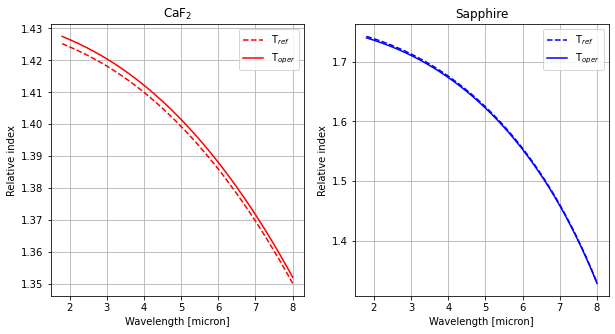

In [5]:
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ax0.plot(wl, ncaf_abs, 'r--', label='T$_{ref}$')
ax0.plot(wl, ncaf, 'r', label='T$_{oper}$')
ax0.set_title('CaF$_2$')

ax1.plot(wl, nsap_abs, 'b--', label='T$_{ref}$')
ax1.plot(wl, nsap, 'b', label='T$_{oper}$')
ax1.set_title('Sapphire')
for ax in (ax0, ax1):
    ax.legend()
    ax.set_xlabel('Wavelength [micron]')
    ax.set_ylabel('Relative index')
    ax.grid()

Airs CH0

In [6]:
# Prism 
wl0, wl1 = 1.75, 3.9
wlc = 0.5*(wl0+wl1)
idx = np.argmin(np.abs(wl-wl0))
ncaf0 = ncaf[idx]
nsap0 = nsap[idx]

theta_1 = np.deg2rad(72.1)
theta_2 = np.deg2rad(-41.9)
theta_3 = np.deg2rad(-37.6)
theta_4 = np.deg2rad(60.3)
thickness = 17.0e-3 # m

A = np.cos(theta_2)*np.cos(theta_4)/(np.cos(theta_1)*np.cos(theta_3))
B = np.cos(theta_1)*np.cos(theta_4)/(np.cos(theta_2)*np.cos(theta_3))/ncaf0
C = 0.0
D = 1.0/A

abcdt = paos.ABCD()
abcdt.ABCD = np.array([[A,B], [C,D]])
abcds = paos.ABCD()
abcds.ABCD= np.array([[1, thickness/ncaf0], [0, 1]])

print('           {:>10s}|{:>10s}|{:>10s}|{:>10s}'.format('power', 'M', 'Thickness', 'n1/n2'))
print("Tangential {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}".format(abcdt.power, abcdt.M, abcdt.thickness, abcdt.n1n2))
print("Sagittal   {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}".format(abcds.power, abcds.M, abcds.thickness, abcds.n1n2))
print("---------------------")
print("Lens units are meters")

                power|         M| Thickness|     n1/n2
Tangential  -0.000000|     1.514|  0.273947|      1.00
Sagittal    -0.000000|     1.000|  0.011909|      1.00
---------------------
Lens units are meters


In [7]:
# First doublet
abcd = paos.ABCD(thickness = 2.695, curvature =  1.0/31.850,  n1 = 1.0,   n2 = ncaf0)
abcd = paos.ABCD(thickness = 0.5,   curvature = -1.0/150.608, n1 = ncaf0, n2 = 1.0)*abcd
abcd = paos.ABCD(thickness = 1.0,   curvature =  1.0/26.524,  n1 = 1.0,   n2 = nsap0)*abcd
abcd = paos.ABCD(thickness = 0.0,   curvature =  1.0/20.797,  n1 = nsap0, n2 = 1.0)*abcd
(A, B), (C, D) = abcd.ABCD

print('           {:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}'.format('f', 'M', 'Thickness', 'n1/n2', 'Dist. to focus'))
print("Tangential {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -D/C))
print("Sagittal   {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -D/C))
print("--------------------------")
print("Lens units are millimeters")

                    f|         M| Thickness|     n1/n2|Dist. to focus
Tangential 100.430445|     0.969|  2.828408|      1.00|    106.95
Sagittal   100.430445|     0.969|  2.828408|      1.00|    106.95
--------------------------
Lens units are millimeters


In [8]:
# Second doublet
abcd = paos.ABCD(thickness = 5.000, curvature =  1.0/91.219,  n1 = 1.0,   n2 = ncaf0)
abcd = paos.ABCD(thickness = 0.955, curvature = -1.0/59.189,  n1 = ncaf0, n2 = 1.0)*abcd
abcd = paos.ABCD(thickness = 1.0,   curvature = -1.0/56.053,  n1 = 1.0,   n2 = nsap0)*abcd
abcd = paos.ABCD(thickness = 0.0,   curvature = -1.0/88.535,  n1 = nsap0, n2 = 1.0)*abcd
(A, B), (C, D) = abcd.ABCD

print('           {:>10s}|{:>10s}|{:>10s}|{:>10s}|{:>10s}'.format('f', 'M', 'Thickness', 'n1/n2', 'Dist. to focus'))
print("Tangential {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -A/C))
print("Sagittal   {:10.6f}|{:10.3f}|{:10.6f}|{:10.2f}|{:10.2f}".format(1/abcd.power, abcd.M, abcd.thickness, abcd.n1n2, -A/C))
print("--------------------------")
print("Lens units are millimeters")

                    f|         M| Thickness|     n1/n2|Dist. to focus
Tangential 142.320730|     1.009|  5.071958|      1.00|    137.25
Sagittal   142.320730|     1.009|  5.071958|      1.00|    137.25
--------------------------
Lens units are millimeters
